# Reward weights analysis

The overall reward is given by
$$
R_t = R_{goal} + R_{collision} + w_1 R_{dist} + w_2 R_{speed} + w_3 R_{smooth}
$$
where
$$R_{dist} = \frac{d_{goal,t} - d_{goal,t-1}}{v_{max}*dt} \in [-1, 1]$$
$$R_{speed,expectile} = 1 - \frac{l_2^\tau(v_t-v_{ref}) * 2}{max(l_2^\tau(-v_{ref}), l_2^\tau(v_{max}-v_{ref}))} \in [-1, 1]$$

with expectile being defined as 
$$
l_2^\tau = \begin{cases}
    \tau x^2 & \text{if } x>0 \\
    \tau x^2 & otherwise
\end{cases}
$$
and
$$R_{smooth} = 1 - \frac{2}{n} \sum_i |a_{i,t}| \in [-1, 1]$$
with $a$ being the action (acceleration) at timestep $t$.

The weight vector $w = [w_1, w_2, w_3]$ sums up to 1. Those weights are the main tuning parameters of the reward function.

Another way to design a curriculum is to smoothly update a curriculum factor $k_c \in (0,1)$ as $k_{c,t+1} \leftarrow k_{c,t}^{k_d}$ where $k_d \in (0, 1)$ is an advance rate.

The reward would then be calculated as
$$
R_t = R_{goal} + (1-\alpha) R_{d_{goal}} + k_c R_{collision} + \alpha k_c \left[ R_{speed} + R_{smooth} + R_{d_{track}} \right] 
$$

The $\alpha$ defines the emphasis on the constraints and thus the agents behavior. The bigger $\alpha$ becomes, the harder it is to explore whereas constraints are less satisfied when $\alpha$ is low. The hypothesis is that curriculum learning enable successful learning for a higher range of $\alpha$ compared to setting $k_c=1$ from start.

The questions this notebook aims to answer are:

1. What is the range of $\alpha$ that allows convergence for normal learning?
2. Can this feasible range be increased by a reward curriculum? 

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import wandb

In [3]:
import matplotlib.pyplot as plt

In [186]:
kc = 0.94
k0 = 0.001

ks = [k0]
for i in range(100):
    k = ks[-1]**kc
    ks.append(k)

In [187]:
ks[-1]

0.985905695913124

In [188]:
ks[50]

0.7311522491848397

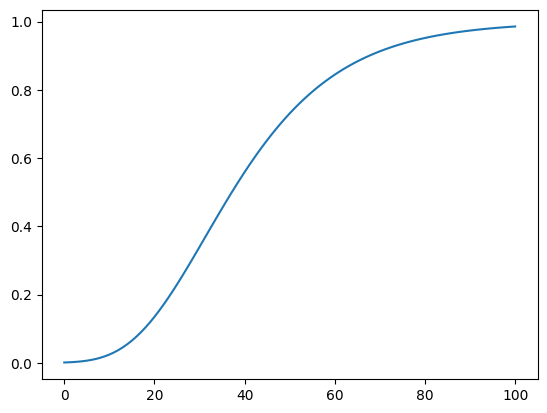

In [189]:
plt.plot(ks)

In [212]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize wandb
api = wandb.Api()

def extract_data(sweep):
    data = []
    for run in sweep.runs:
        params = run.config
        metrics = run.summary
    
        reward_mode = params.get('reward_mode')
        alpha = params.get('alpha')
        success_rate = metrics.get('eval/episode_success')
        ep_len = metrics.get('eval/episode_length')
        ep_reward = metrics.get('eval/episode_reward')
    
        data.append({
            'reward_mode': reward_mode,
            'alpha': alpha,
            'success_rate': success_rate,
            'episode_length': ep_len,
            'episode_reward': ep_reward,
        })
    return data

dynamic_sweep = api.sweep("kilian/DRL-Traj-Planner/mx52741g")
data_dynamic = extract_data(dynamic_sweep)

static_sweep = api.sweep("kilian/DRL-Traj-Planner/zee28sva")
data_static = extract_data(static_sweep)

corridor_sweep = api.sweep("kilian/DRL-Traj-Planner/if5qmjao")
data_corridor = extract_data(corridor_sweep)

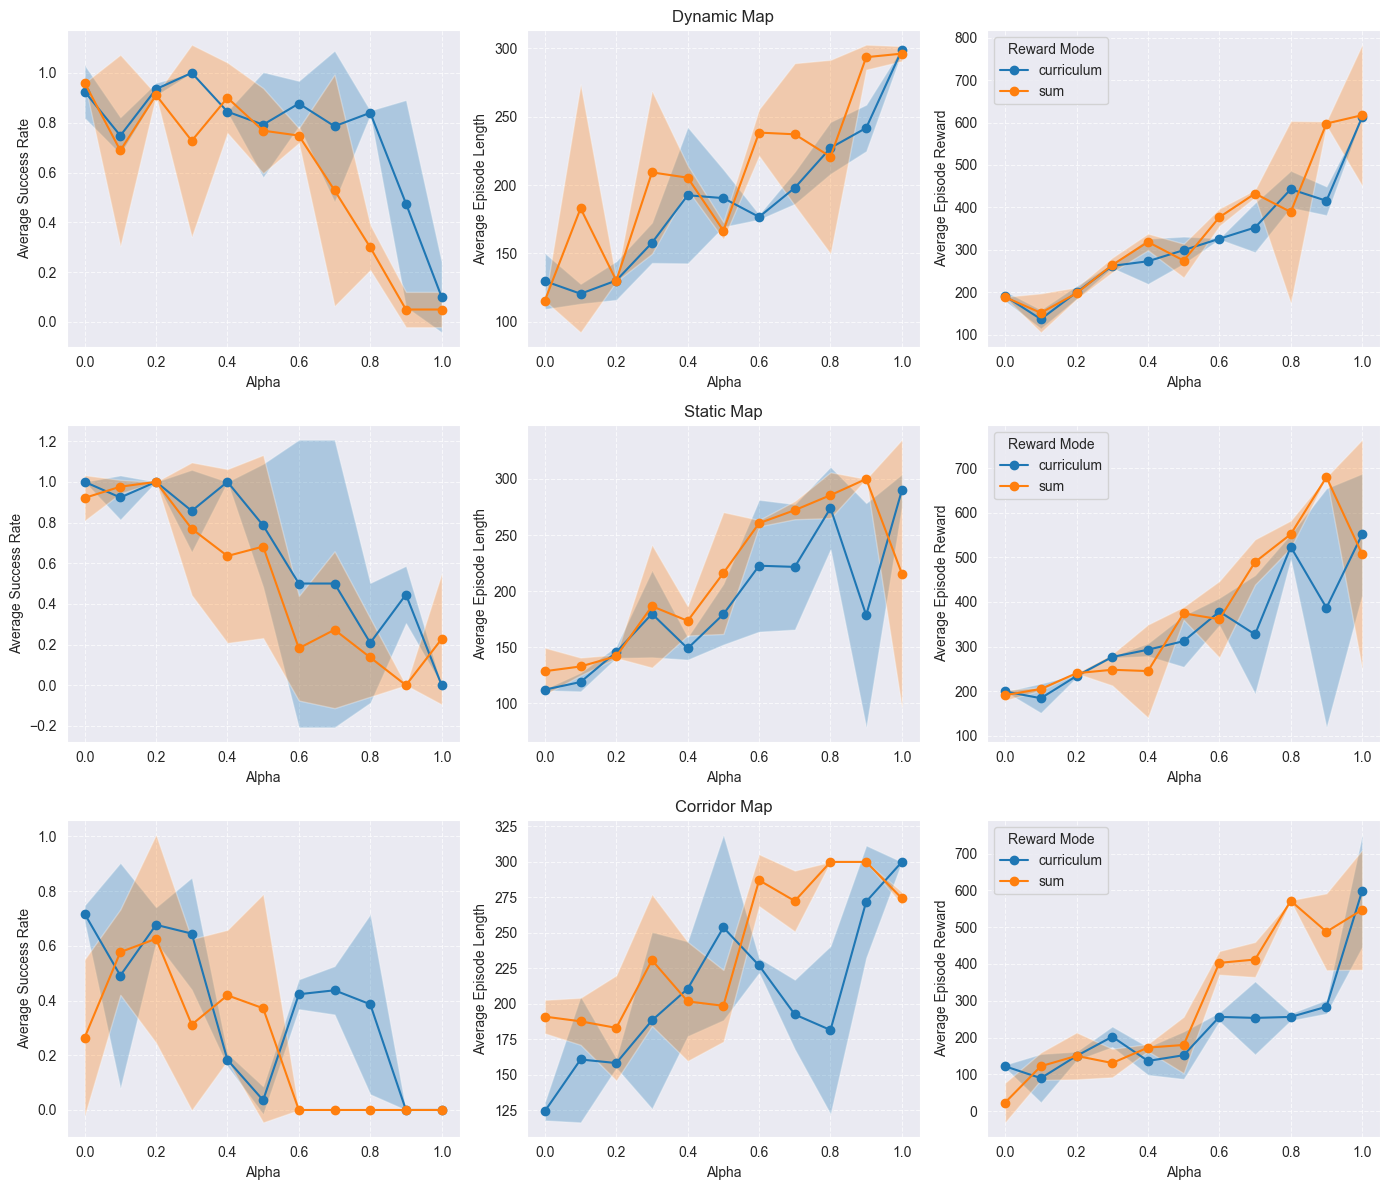

In [214]:
def process_and_plot(data, ax, title):
    df = pd.DataFrame(data)
    df_grouped = df.groupby(['reward_mode', 'alpha']).agg({
        'success_rate': ['mean', 'std'],
        'episode_length': ['mean', 'std'],
        'episode_reward': ['mean', 'std'],
    }).reset_index()
    df_grouped.columns = ['reward_mode', 'alpha',
                          'success_rate_mean', 'success_rate_std',
                          'episode_length_mean', 'episode_length_std',
                          'episode_reward_mean', 'episode_reward_std']

    for mode in df_grouped['reward_mode'].unique():
        mode_data = df_grouped[df_grouped['reward_mode'] == mode]
        ax[0].plot(mode_data['alpha'], mode_data['success_rate_mean'], marker='o', label=mode)
        ax[0].fill_between(mode_data['alpha'], 
                         mode_data['success_rate_mean'] - mode_data['success_rate_std'],
                         mode_data['success_rate_mean'] + mode_data['success_rate_std'],
                         alpha=0.3)
        
        ax[1].plot(mode_data['alpha'], mode_data['episode_length_mean'], marker='o', label=mode)
        ax[1].fill_between(mode_data['alpha'], 
                         mode_data['episode_length_mean'] - mode_data['episode_length_std'],
                         mode_data['episode_length_mean'] + mode_data['episode_length_std'],
                         alpha=0.3)

        ax[2].plot(mode_data['alpha'], mode_data['episode_reward_mean'], marker='o', label=mode)
        ax[2].fill_between(mode_data['alpha'], 
                         mode_data['episode_reward_mean'] - mode_data['episode_reward_std'],
                         mode_data['episode_reward_mean'] + mode_data['episode_reward_std'],
                         alpha=0.3)

    ax[1].set_title(title)
    ax[0].set_xlabel('Alpha')
    ax[0].set_ylabel('Average Success Rate')
    ax[1].set_xlabel('Alpha')
    ax[1].set_ylabel('Average Episode Length')
    ax[2].set_xlabel('Alpha')
    ax[2].set_ylabel('Average Episode Reward')
    ax[2].legend(title='Reward Mode')
    ax[0].grid(True, linestyle='--', alpha=0.7)
    ax[1].grid(True, linestyle='--', alpha=0.7)
    ax[2].grid(True, linestyle='--', alpha=0.7)

fig, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(14, 12))

process_and_plot(data_dynamic, ax1, 'Dynamic Map')
process_and_plot(data_static, ax2, 'Static Map')
process_and_plot(data_corridor, ax3, 'Corridor Map')
plt.tight_layout()
plt.show()

According to the plots a curriculum reward can enable convergence for a longer range of $\alpha$. Further, it never seems detrimental to employ curriculum learning. Note that even for $\alpha=0$, there exists a curriculum which by time increases the collision penalty. Nevertheless, it seems that the constraint terms have a higher impact of an agent's performance.

Interestingly, the episode reward and success rate do not show the same trends. A reason for this might be that the agent without curriculum learns to exploit the reward function for regions with high reward but without success whereas curriculum learning tends to prevent reward exploitation. Additionally, episodes tend to become longer with increased constraints.